In [1]:
import os
import pathlib
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import soundfile as sf
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython import display

seed = 35
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# pip install sounddevice

In [4]:
# pip install wavio

In [5]:
# pip install scipy

In [6]:
Path = "data.zip"


with zipfile.ZipFile(Path) as scream_zip:
  scream_zip.extractall("content")

In [7]:
scream_path = 'content/data'

commands = np.array(tf.io.gfile.listdir(str('content/data/')))
print('file : ', commands)

file :  ['silent' 'speech' 'tolong']


In [8]:
filenames = tf.io.gfile.glob(str(scream_path) +'/*/*.wav')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print("files : ", num_samples)
# print('tensor : ', filenames)

files :  697


In [9]:
import librosa
from pydub import AudioSegment
filenames = tf.io.gfile.glob(str(scream_path) + '/*/*.wav')
for i in filenames:
  sound = AudioSegment.from_wav(i)
  sound = sound.set_channels(1)
  sound.export(i, format="wav")

In [10]:
filenames = tf.random.shuffle(filenames)
train_files = filenames[:844]
val_files = filenames[547:547 + 106]
test_files = filenames[-105:]

print(len(train_files))
print(len(val_files))
print(len(test_files))



697
106
105


In [11]:
test_file = tf.io.read_file(scream_path + '/tolong/tolong72.wav')
test_audio, _ = tf.audio.decode_wav(contents= test_file)
test_audio.shape

TensorShape([25985, 1])

In [12]:
ob = sf.SoundFile(scream_path + '/tolong/32.wav')
print('Sample rate: {}'.format(ob.samplerate))
print('Channels: {}'.format(ob.channels))
print('Subtype: {}'.format(ob.subtype))

Sample rate: 16000
Channels: 1
Subtype: PCM_16


In [13]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis = -1)


In [14]:
def get_label(file_path):
  parts = tf.strings.split(
      input = file_path,
      sep = os.path.sep
  )
  return parts[-2]

In [15]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

file_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = file_ds.map(
    map_func = get_waveform_and_label,
    num_parallel_calls= AUTOTUNE
)

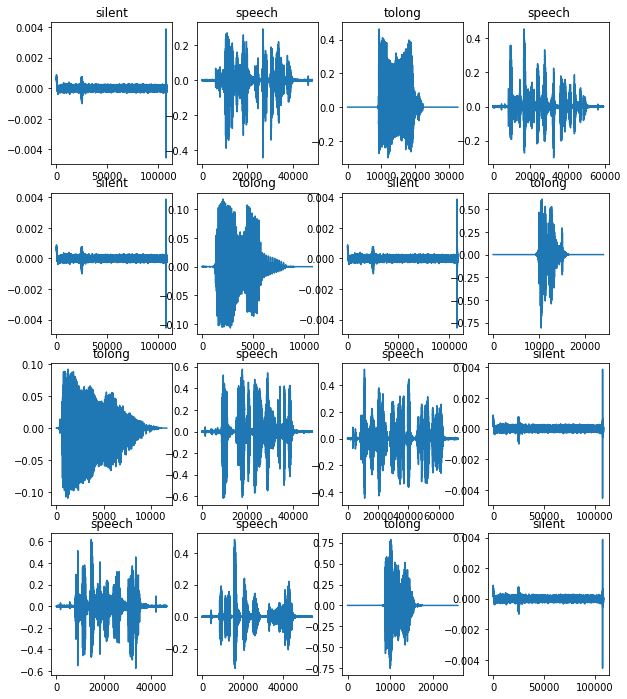

In [17]:
rows = 4
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  label = label.numpy().decode('utf-8')
  ax.set_title(label)


plt.show()

In [18]:
def get_spectrogram(waveform):
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype = tf.float32
  )

  waveform =  tf.cast(waveform, dtype = tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)

  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128
  )

  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


In [19]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label : ', label)
print('Waveform shape : ', waveform.shape)
print('Spectrogram shape', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=14000))

Label :  silent
Waveform shape :  (108353,)
Spectrogram shape (124, 129, 1)
Audio playback


In [20]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis= -1)
  
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num= width, dtype= int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)
  # print(X)
  # print(Y)

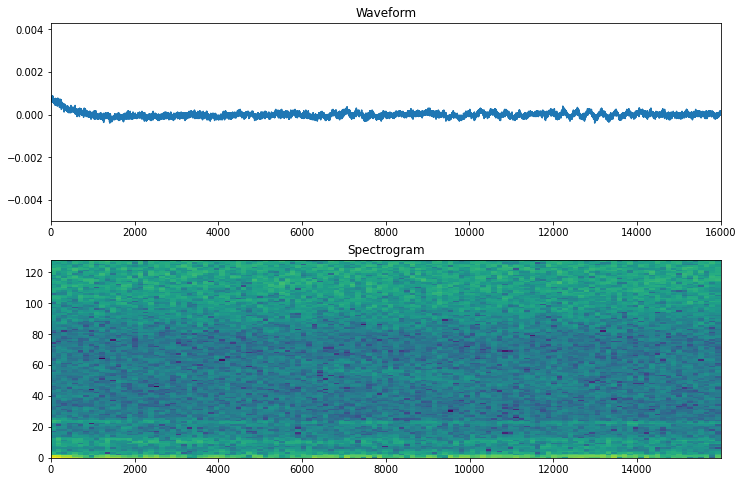

In [21]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [22]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

In [23]:
spectrogram_ds = waveform_ds.map(
    map_func = get_spectrogram_and_label_id,
    num_parallel_calls= AUTOTUNE
)

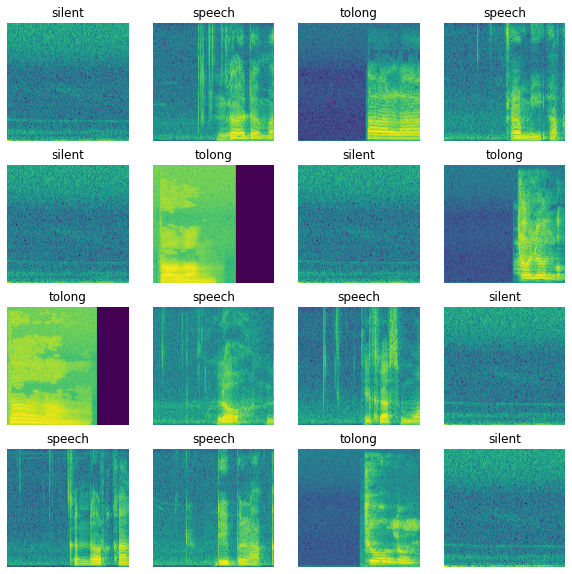

In [24]:
rows = 4
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [25]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func = get_waveform_and_label,
      num_parallel_calls= AUTOTUNE
  )
  output_ds = output_ds.map(
      map_func = get_spectrogram_and_label_id,
      num_parallel_calls = AUTOTUNE
  )
  return output_ds

In [26]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [27]:
batch_size = 50
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [28]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [29]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
num_labels = len(commands)
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
                           layers.Input(shape = input_shape),
                           # Downsample the input.
                           layers.Resizing(128, 128),
                           # Normalize.
                           norm_layer,
                           layers.Conv2D(64, 3, activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Conv2D(64, 3, activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Conv2D(128, 3, activation='relu'),
                           layers.MaxPooling2D(),
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dropout(0.2),
                           layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 128, 128, 1)       0         
                                                                 
 normalization (Normalizatio  (None, 128, 128, 1)      3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [31]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
14/14 [==============================] - 51s 3s/step - loss: 0.5056 - accuracy: 0.8049 - val_loss: 0.1768 - val_accuracy: 0.9434
Epoch 2/10
14/14 [==============================] - 30s 2s/step - loss: 0.2138 - accuracy: 0.9354 - val_loss: 0.0927 - val_accuracy: 0.9811
Epoch 3/10
14/14 [==============================] - 29s 2s/step - loss: 0.1038 - accuracy: 0.9742 - val_loss: 0.0559 - val_accuracy: 0.9906
Epoch 4/10
14/14 [==============================] - 30s 2s/step - loss: 0.0803 - accuracy: 0.9828 - val_loss: 0.0507 - val_accuracy: 0.9906
Epoch 5/10
14/14 [==============================] - 27s 2s/step - loss: 0.0731 - accuracy: 0.9857 - val_loss: 0.0454 - val_accuracy: 0.9906
Epoch 6/10
14/14 [==============================] - 27s 2s/step - loss: 0.0771 - accuracy: 0.9842 - val_loss: 0.0463 - val_accuracy: 0.9906
Epoch 7/10
14/14 [==============================] - 27s 2s/step - loss: 0.0694 - accuracy: 0.9857 - val_loss: 0.0446 - val_accuracy: 0.9906
Epoch 8/10
14/14 [==

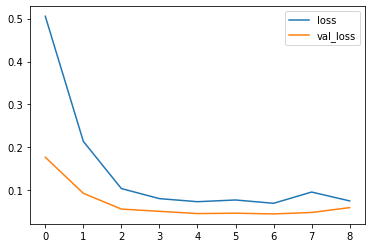

In [32]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [33]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [34]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 99%


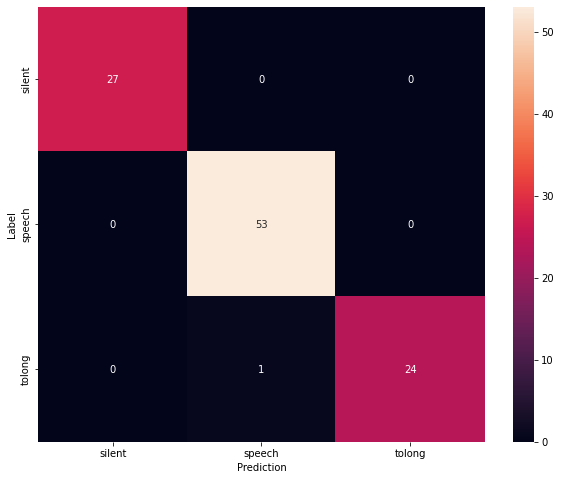

In [35]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [36]:
import pathlib

export = '/content/saved_model'
tf.saved_model.save(model, export)

#optimization
optimization = tf.lite.Optimize.DEFAULT

#convert
converter = tf.lite.TFLiteConverter.from_saved_model(export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

#save
tflite_model_file = export + '/convert_model.tflite'
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /content/saved_model/assets
